[✓] Rerun with updated EmotiW dataset

[✓] Rerun with updated data generation code

### Pose Classifier (v5)

This notebook aggregates the pose information over time by averaging the pose keypoints for each frame.

Note, in comparison with the previous notebooks, we learned that we were using the wrong dtype for the "X" variable. This means we cannot combine with images as we did in previous notebooks because images are uint8 where as normalized pose information is float type.

**Best Model (Val Loss): 64LSTM-reg**

Epoch 00011: val_loss improved from 1.08561 to 1.03560, saving model to drive/My Drive/checkpoints/pose-classifier-v5.1/cp-0011.h5
41/41 [==============================] - 33s 802ms/step - loss: 1.0124 - accuracy: 0.5225 - val_loss: 1.0356 - val_accuracy: 0.4815



In [1]:
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp 'drive/My Drive/cs231n-project/datasets/emotiw/train_frames_keypoints.tar.gz' .

In [0]:
!tar -xzf train_frames_keypoints.tar.gz

In [4]:
!ls train_frames_keypoints/3 | wc -l

13248


In [0]:
!cp 'drive/My Drive/cs231n-project/datasets/emotiw/val_frames_keypoints.tar.gz' .


In [0]:
!tar -xzf val_frames_keypoints.tar.gz

In [7]:
!nvidia-smi

Mon Jun  1 18:33:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
import random
import cv2
from os import listdir
from os.path import isfile, join
import os
import matplotlib.pyplot as plt
import tensorflow as tf


class DataGenerator(tf.keras.utils.Sequence):
    """
    Generates keypoint data across each frame
    """
    def __init__(self, keyframe_dir, batch_size=32, frames_to_use=-1, shuffle=True):
        self.frames_to_use = frames_to_use
        self.batch_size = batch_size
        self.keyframe_dir = keyframe_dir
        self.shuffle = shuffle
        self.classes = self.find_classes()
        self.video_names, self.video_map, self.video_to_class, self.num_samples, self.min_frames = self.find_samples()
        self.on_epoch_end()
        print(f"Found {self.num_samples} frames belonging to {len(self.video_names)} videos belonging to {len(self.classes)} classes.")
        print(f"Min frames determined to be {self.min_frames}")

    def find_classes(self):
        category_folders = [f for f in listdir(self.keyframe_dir) if not isfile(join(self.keyframe_dir, f))]
        return sorted(list(set(category_folders)))

    def find_samples(self):
        """
        Returns the following video frame structure:
        """
        num_samples = 0
        min_frames = -1
        video_map = {}
        vid_to_cat = {}
        category_folders = [f for f in listdir(self.keyframe_dir) if not isfile(join(self.keyframe_dir, f))]
        print(category_folders)
        for category_folder in category_folders:
            cat_path = join(self.keyframe_dir, category_folder)
            frames = [f for f in listdir(cat_path) if isfile(join(cat_path, f))]
            for frame in frames:
                frame_arr = frame.split(".mp4_")
                vid_name = frame_arr[0]
                if vid_name not in video_map:
                    video_map[vid_name] = []
                    vid_to_cat[vid_name] = category_folder
                video_map[vid_name].append(frame)
            
            i = 0
            for k in video_map.keys():
                # make sure the frames for each video are in sorted order
                video_map[k] = sorted(video_map[k], key=lambda x: x.split(".mp4_")[0] + x.split(".mp4_")[1].split("_keypoints")[0].zfill(3))
                if min_frames == -1 or len(video_map[k]) < min_frames:
                    min_frames = len(video_map[k])

        return list(video_map.keys()), video_map, vid_to_cat, len(vid_to_cat), min_frames

    def get_body_joints(self, x):
        body_parts = [
            1, # neck       --
            2, # r shoulder
            3, # r elbow
            4, # r wrist
            5, # l shoulder
            6, # l elbow
            7, # l wrist
            9, # r hip
            10, # r knee
            11, # r ankle
            12, # l hip
            13, # l knee
            14, # l ankle   -- 
        ]
        body_parts_xy = []
        for b in body_parts:
            body_parts_xy.append(b * 3)
            body_parts_xy.append(b * 3 + 1)
        return x[body_parts_xy]

    def normalize(self, x_input):
        # Separate original data into x_list and y_list
        lx = []
        ly = []
        N = len(x_input)
        i = 0
        while i<N:
            lx.append(x_input[i])
            ly.append(x_input[i+1])
            i+=2
        lx = np.array(lx)
        ly = np.array(ly)

        # Get rid of undetected data (=0)
        non_zero_x = []
        non_zero_y = []
        for i in range(int(N/2)):
            if lx[i] != 0:
                non_zero_x.append(lx[i])
            if ly[i] != 0:
                non_zero_y.append(ly[i])
        if len(non_zero_x) == 0 or len(non_zero_y) == 0:
            return np.array([0] * N)

        # Normalization x/y data according to the bounding box
        origin_x = np.min(non_zero_x)
        origin_y = np.min(non_zero_y)
        len_x = np.max(non_zero_x) - np.min(non_zero_x)
        len_y = np.max(non_zero_y) - np.min(non_zero_y)
        x_new = []
        for i in range(int(N/2)):
            if (lx[i] + ly[i]) == 0:
                x_new.append(-1)
                x_new.append(-1)
            else:
                x_new.append((lx[i] - origin_x) / len_x)
                x_new.append((ly[i] - origin_y) / len_y)
        return x_new

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.floor(self.num_samples / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        video_names = self.video_names[index*self.batch_size:(index+1)*self.batch_size]
        num_frames = self.min_frames if self.frames_to_use == -1 else self.frames_to_use
        X = np.zeros((len(video_names), num_frames, 13 * 2 + 1), dtype=np.float64)
        y = []
        i = 0
        for vid in video_names:
            j = 0
            for frame in self.video_map[vid]:
                keypoint_file = join(join(self.keyframe_dir, self.video_to_class[vid]), frame)
                with open(keypoint_file) as json_file:
                    keypoint_data = json.load(json_file)

                    # Extract some features from the keypoint data like averaging
                    arrs = []

                    for person in keypoint_data["people"]:
                        # Each person is assigned the label of the video
                        kp = np.array(person["pose_keypoints_2d"])
                        kp = self.get_body_joints(kp)
                        kp = self.normalize(kp)
                        arrs.append(kp)
                        # if i == 0 and j == 0:
                        #     print(kp)
                    
                    if len(arrs) > 0:
                        arrs = np.array(arrs)
                        features = []
                        features.extend(np.average(arrs, axis=0).tolist())
                        features.append(len(keypoint_data["people"]))
                        features = np.array(features)
                        features[np.isnan(features)] = -1
                        X[i, j, :] = np.array(features)
                    
                j += 1
                if j >= num_frames:
                    break

            y.append(int(self.video_to_class[vid]) - 1)
            i += 1
        y = np.array(y)
        return X, tf.keras.utils.to_categorical(y, num_classes=len(self.classes))

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.video_names)




In [0]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

IMG_WIDTH = 480
IMG_HEIGHT = 320
BATCH_SIZE = 64
MODEL_NAME = "pose-classifier-v5"
FRAMES = 12


In [10]:
import json
train_generator = DataGenerator("train_frames_keypoints", frames_to_use=12, batch_size=BATCH_SIZE)
validation_generator = DataGenerator("val_frames_keypoints", frames_to_use=12, batch_size=BATCH_SIZE)

X, y = train_generator.__getitem__(0)
# print(X.shape)
# print(y)


X, y = validation_generator.__getitem__(0)
# print(X.shape)
# print(y)

['1', '3', '2']
Found 2661 frames belonging to 2661 videos belonging to 3 classes.
Min frames determined to be 7
['1', '3', '2']
Found 766 frames belonging to 766 videos belonging to 3 classes.
Min frames determined to be 7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in double_scalars


In [11]:
from pathlib import Path

Path(f"drive/My Drive/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/checkpoints/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    period=1)

def create_model(inputs):
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2()))(inputs)
    x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

inputs = tf.keras.Input(shape=(FRAMES, 2 * 13 + 1))
model = create_model(inputs)
model.summary()




Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 27)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                15360     
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.evaluate(train_generator, steps = 3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in double_scalars


3/3 [==============================] - 1s 220ms/step - loss: 2.0879 - accuracy: 0.4167


[2.0879271030426025, 0.4166666567325592]

In [13]:
import pickle
history = model.fit(
          train_generator,
          epochs=20,
          callbacks=[cp_callback],
          validation_data=validation_generator
)

with open(f"drive/My Drive/checkpoints/{MODEL_NAME}/history.pkl", 'wb') as handle:
    pickle.dump(history.history, handle)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in double_scalars


Epoch 1/20
41/41 [==============================] - ETA: 0s - loss: 1.8346 - accuracy: 0.4375
Epoch 00001: val_loss improved from inf to 1.61451, saving model to drive/My Drive/checkpoints/pose-classifier-v5/cp-0001.h5
41/41 [==============================] - 32s 787ms/step - loss: 1.8346 - accuracy: 0.4375 - val_loss: 1.6145 - val_accuracy: 0.4503
Epoch 2/20
41/41 [==============================] - ETA: 0s - loss: 1.4977 - accuracy: 0.4676
Epoch 00002: val_loss improved from 1.61451 to 1.38634, saving model to drive/My Drive/checkpoints/pose-classifier-v5/cp-0002.h5
41/41 [==============================] - 32s 781ms/step - loss: 1.4977 - accuracy: 0.4676 - val_loss: 1.3863 - val_accuracy: 0.4446
Epoch 3/20
41/41 [==============================] - ETA: 0s - loss: 1.3014 - accuracy: 0.4813
Epoch 00003: val_loss improved from 1.38634 to 1.23450, saving model to drive/My Drive/checkpoints/pose-classifier-v5/cp-0003.h5
41/41 [==============================] - 32s 778ms/step - loss: 1.3014 

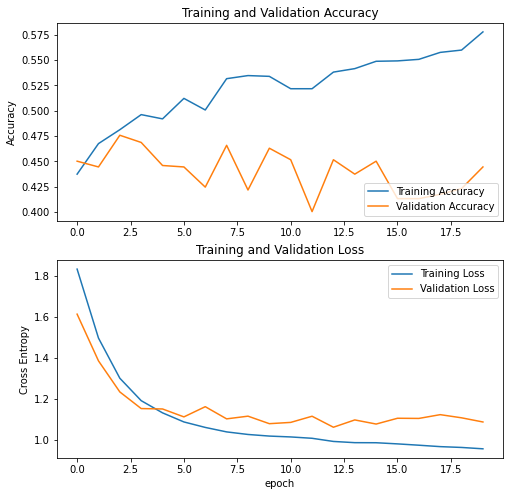

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### Let's try more neurons?

In [0]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

IMG_WIDTH = 480
IMG_HEIGHT = 320
BATCH_SIZE = 64
MODEL_NAME = "pose-classifier-v5.1"
FRAMES = 12


In [16]:
from pathlib import Path

Path(f"drive/My Drive/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/checkpoints/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    period=1)

def create_model(inputs):
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2()))(inputs)
    x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

inputs = tf.keras.Input(shape=(FRAMES, 2 * 13 + 1))
model = create_model(inputs)
model.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12, 27)]          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               47104     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 47,491
Trainable params: 47,491
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in double_scalars


Epoch 1/20
41/41 [==============================] - ETA: 0s - loss: 1.8371 - accuracy: 0.4345
Epoch 00001: val_loss improved from inf to 1.55400, saving model to drive/My Drive/checkpoints/pose-classifier-v5.1/cp-0001.h5
41/41 [==============================] - 32s 788ms/step - loss: 1.8371 - accuracy: 0.4345 - val_loss: 1.5540 - val_accuracy: 0.4531
Epoch 2/20
41/41 [==============================] - ETA: 0s - loss: 1.4188 - accuracy: 0.4794
Epoch 00002: val_loss improved from 1.55400 to 1.32161, saving model to drive/My Drive/checkpoints/pose-classifier-v5.1/cp-0002.h5
41/41 [==============================] - 33s 796ms/step - loss: 1.4188 - accuracy: 0.4794 - val_loss: 1.3216 - val_accuracy: 0.4560
Epoch 3/20
41/41 [==============================] - ETA: 0s - loss: 1.2208 - accuracy: 0.4931
Epoch 00003: val_loss improved from 1.32161 to 1.18274, saving model to drive/My Drive/checkpoints/pose-classifier-v5.1/cp-0003.h5
41/41 [==============================] - 32s 793ms/step - loss: 1

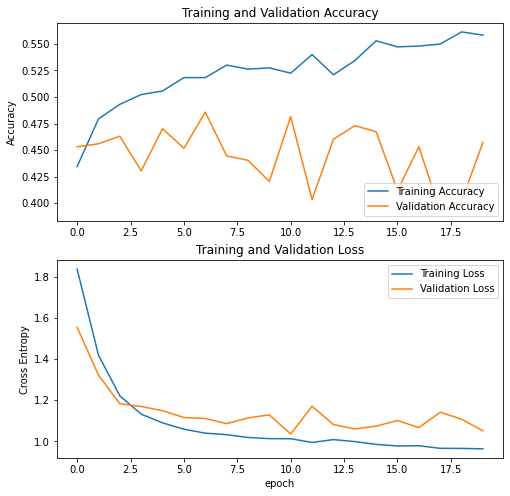

In [17]:


import pickle
history = model.fit(
          train_generator,
          epochs=20,
          callbacks=[cp_callback],
          validation_data=validation_generator
)

with open(f"drive/My Drive/checkpoints/{MODEL_NAME}/history.pkl", 'wb') as handle:
    pickle.dump(history.history, handle)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### Transfer Best Model to GCS

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [18]:


from google.colab import auth
auth.authenticate_user()
project_id = 'calm-depot-274104'
!gcloud config set project {project_id}
!gsutil ls

# !gsutil -m cp -r drive/My\ Drive/checkpoints/pose-classifier-v5.1/m1.h5 gs://cs231n-emotiw/models/pose-classifier-bestloss-64lstm-0.01reg.h5

# Upload the best loss model
!gsutil -m cp -r drive/My\ Drive/checkpoints/pose-classifier-v5.1/cp-0011.h5 gs://cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5

Updated property [core/project].
gs://cs231n-emotiw/
Copying file://drive/My Drive/checkpoints/pose-classifier-v5.1/cp-0011.h5 [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/598.5 KiB.                                    
